# Задание №3. Деинтерлейсинг

## Описание

Задание разделено на 2 большие части:

### 1. Эвристический алгоритм

Реализовать эвристический алгоритм деинтерлейсинга, основанный на любых алгоритмах, расказанных (и не расказанных) на лекции.

**Требования**:
* работает не дольше 5 FPS
* использует _только_ те пакеты, которые указаны в файле `requirements.txt`

### 2. Нейросетевой алгоритм

Реализовать нейросетевой алгоритм деинтерлейсинга.

**Требования**:
* модель реализована на фреймворке TensorFlow / Keras
* обучение происходило _только_ на предоставленной обучающей выборке (но можно использовать разумное размножение выборки)

### Общие требования

* соблюдать [кодекс чести](https://communitystandards.stanford.edu/policies-and-guidance/honor-code). Виновные будут найдены и наказаны.

## Оценивание

1. Каждый участник может представить не более 1 эвристического алгоритма и не более 1 нейросетевого алгоритма для финального   тестирования

2. Тестирование будет проводиться на закрытой тестовой выборке, содержащей N (N < 10) тестовых видео

3. В качестве метрик будут использованы:
    * PSNR
    * SSIM
    
4. По итогам тестирования будет составлена общая таблица результатов по каждой из метрик

5. Место каждого алгоритма определяется по формуле: $Place_{algo} = \frac{Place_{PSNR} + Place_{SSIM}}{2}$

6. Баллы за конкретный алгоритм зависят от его места: $Score_{algo} = score(Place_{algo})$

7. Баллы участника складываются из баллов за эвристический алгоритм и нейросетевой алгоритм: $Score_{stud} = Score_{heuristic}^{stud} + Score_{neural}^{stud}$

8. Если какой-либо алгоритм не представлен студентом или не выполнены _требования_ — это эквивалентно обнулению соответствующего значения: $Score_{algo}^{stud} = 0$

## Повторение

* [Статья на Хабре](https://habr.com/en/post/51201/) про развёртки
* [Статья на Хабре](https://habr.com/en/post/61822/) про методы деинтерлейсинга

_Прогрессивная развёртка (построчная развёртка)_ — способ трансляции и хранения видео, при котором в каждом кадре все строки отображаются последовательно.

_Интерлейсинг (чересстрочная развёртка)_ — способ трансляции и хранения видео, при котором каждый кадр разбивается на два поля (чётное и нечётное).

<img src="extra/interlacing-scheme.gif" width="300"/>

* _Top Field (Odd Field, чётное поле)_ — чётные строки кадра
* _Bottom Field (Even Field, нечётное поле)_ — нечётные строки кадра

То, какое поле (чётное или нечётное) отвечает за более ранний момент времени — настраиваемый параметр. Обычно чётное поле по времени не позже нечётного

При интерлейсинге:
* частота кадров *увеличивается в 2 раза* относительно исходного видео в прогрессивной развёртке
* разрешение каждого отдельного кадра *уменьшается в 2 раза*

Это происходит из-за того, что в каждый момент времени на экране отображается только один полукадр.

![interlaced-vs-progressive](extra/interlaced-vs-progressive.jpg)

_Деинтерлейсинг_ — преобразование из чересстрочной развёртки в прогрессивную без потери частоты кадров.

## Часть 1. Эвристический деинтерлейсер

Устанавка всего необходимого

In [ ]:
# pip install -r requirements.txt

Необходимые импорты

In [1]:
import cv2                       # Библиотека компьютерного зрения OpenCV.
import matplotlib.pyplot as plt  # Пакет PyPlot для визуализаций и графиков.
import numpy as np               # Библиотека вычислений NumPy.
import os                        # Часть стандартной библиотеки Python, отвечает за системные вызовы.
import skimage.measure
import pyflow

from measure import (
    measure_single               # Эта функция замеряет качество для одного видео по нескольким метрикам.
)

from utils import (
    read_sequence,               # Функция для чтения кадров видео из указанной папки.
    save_image_png,              # Функция для сохранения картинки без сжатия, в формате PNG.
    save_image_jpg,              # Функция для сохранения картинки со сжатием, в формате JPEG.
    extract_fields,              # Функция для извлечения последовательных полей из чересстрочного видео.
    rgb2gray
)


# Папка с видео в чересстрочной развёртке.
INTERLACE_VIDEO_DIR = '../data/interlace/'

# Папка с теми же видео в прогрессивной развёртке.
GT_VIDEO_DIR = '../data/gt/'

### Бэйзлайн: алгоритм Bob
В качестве отправной точки возьмём простейший алгоритм Bob.

Краткое напоминание о том, как он работает:
\begin{equation}
  Pixel_k(x, y) = \begin{cases}
    Pixel_k(x, y), & \text{if $y + k = 0$ mod $2$},\\
    \frac{Pixel_k(x, y - 1) + Pixel_k(x, y + 1)}{2}, & \text{otherwise}.
  \end{cases}
\end{equation}
где $k$ — номер кадра в чересстрочной видеопоследовательности.

In [19]:
def deinterlace_bob(fields, top_frame_first=True):
    num_frames, height, width, num_channels = fields.shape
    # Выделяем память под все итоговые кадры
    deinterlaced = np.zeros((num_frames, height * 2, width, num_channels), dtype='uint8')
    
    for index, field in enumerate(fields):
        for row in range(height * 2):
            residual = (row + index) % 2
            field_row = (row - residual) // 2
            
            if (top_frame_first and residual == 0) or (not top_frame_first and residual == 1):
                deinterlaced[index, row] = field[field_row]
            else:
                if field_row < 0:
                    # Важно приводить к uint8
                    deinterlaced[index, row] = (field[0] / 2).astype('uint8')
                elif field_row + 1 >= height:
                    deinterlaced[index, row] = (field[-1] / 2).astype('uint8')
                else:
                    deinterlaced[index, row] = \
                        np.rint(field[field_row] / 2 + field[field_row + 1] / 2).astype('uint8')
                    
    return deinterlaced

### Проверка работоспособности

#### 1. Считываем чересстрочное видео с помощью функции `read_sequence`:

In [4]:
interlaced_video_folder = os.path.join(INTERLACE_VIDEO_DIR, '1_CrowdRun_1080p50')
interlaced = read_sequence(interlaced_video_folder)

Первое, что мы должны проверить — размерность полученного тензора.

Он представляет собой видео в формате NHWC, где:
* N — кол-во кадров
* H — высота
* W — ширина
* С — число каналов, для цветного изображения C = 3

In [5]:
interlaced.shape

(250, 1080, 1920, 3)

Имеем: 250 цветных кадров разрешением 1920x1080.

Теперь посмотрим, _что_ мы считали. Для этого распечатаем первый кадр с помощью функции `plt.imshow`:

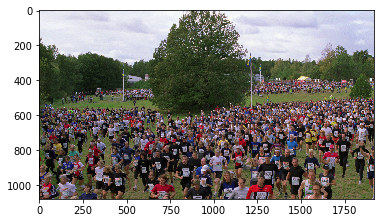

In [6]:
plt.imshow(interlaced[0])

#### 2. Извлекаем последовательные поля из чересстрочного видео:

In [7]:
fields = extract_fields(interlaced, top_frames_first=True)

In [8]:
fields.shape

(500, 540, 1920, 3)

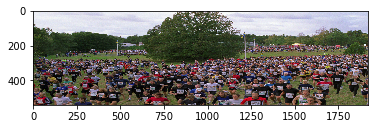

In [9]:
plt.imshow(fields[0])

#### 3. Применяем, наконец, наш алгоритм Bob к последовательным полям:

In [20]:
deinterlaced = deinterlace_bob(fields)

In [65]:
deinterlaced.shape

(500, 1080, 1920, 3)

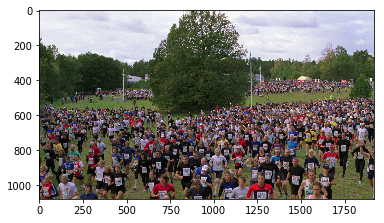

In [66]:
plt.imshow(deinterlaced[0])

### Измерение качества: PSNR, SSIM

* [Peak Signal-to-Noise Ratio (PSNR)](https://en.wikipedia.org/wiki/Structural_similarity)
* [Structural Similarity (SSIM)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)

PSNR и SSIM — full-reference метрики. Это означает, что для их измерения необходимо иметь GT (ground-truth, исходные данные). Помимо full-reference бывают no-reference метрики, не требующие GT.

В нашем случае GT — это видео в progressive-развёртке, из которого было получено interlace-видео искусственным образом.

Считываем GT-видео:

In [17]:
gt_video_folder = os.path.join(GT_VIDEO_DIR, '1_CrowdRun_1080p50')
gt_video = read_sequence(gt_video_folder)

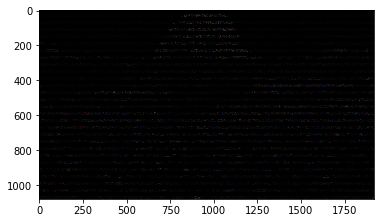

In [21]:
plt.imshow(np.abs(gt_video[0].astype('int16') - deinterlaced[0].astype('int16')))

Вычислим PSNR и SSIM, выдаваемые нашим Bob'ом.

_Замечание_: Вычисление SSIM по целому видео занимает продолжительное время (~10 мин.)

In [22]:
def _psnr(first, second):
    return skimage.measure.compare_psnr(first, second)

def _ssim(first, second):
    return skimage.measure.compare_ssim(first, second, multichannel=True)

In [23]:
metrics = {
    'psnr': _psnr,
    'ssim': _ssim
}

metric_values = measure_single(fields[::10], gt_video[::10], deinterlace_bob, metrics)

In [38]:
metric_values

{'psnr': {'mean': 32.24092476338103, 'std': 0.5987622113639841},
 'ssim': {'mean': 0.9496463731344179, 'std': 0.00145020854421155}}

Теперь ваша задача — максимально улучшить этот результат!

In [27]:
fields[0].shape

(540, 1920, 3)

### Работа с Optical Flow

Определим вспомогательные функции для интерполяции промежуточного кадра. Для вычисления оптического потока будем пользоваться модулем `pyflow`

In [72]:
def warp_image(image, flow, interpolation=cv2.INTER_LANCZOS4):
    mid_flow = -flow / 2
    
    height, width = image.shape[:2]
    map_x = np.ones((height, 1)).dot(np.arange(width).reshape((1, width))) + mid_flow[:,:,0]
    map_y = np.ones((width, 1)).dot(np.arange(height).reshape((1, height))).T + mid_flow[:,:,1]
    
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)
    
    return cv2.remap(image, map_x, map_y, interpolation).clip(0., 1.)

In [74]:
def compute_flow(current_frame, next_frame):
    # Parameters to tune
    alpha = 0.012
    ratio = 0.75
    minWidth = 20
    nOuterFPIterations = 7
    nInnerFPIterations = 1
    nSORIterations = 30
    colType = 0
    
    u, v, im2W = pyflow.coarse2fine_flow(
        current_frame, next_frame, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,
        nSORIterations, colType)
    flow = np.concatenate((u[..., None], v[..., None]), axis=2)
    
    return flow

In [76]:
def interpolate_frames(frames):
    prev_frame = frames[0]
    interpolated_frames = []
    
    for cur_frame in frames[1:]:
        flow = compute_flow(prev_frame, cur_frame)
        intermediate_frame = warp_image(prev_frame, flow.astype(np.float32))
        interpolated_frames.append(intermediate_frame)
        prev_frame = cur_frame
        
    return np.array(interpolated_frames)

Теперь можно пользоваться функцией `interpolate_frames()` для того, чтобы интерполировать поля

In [79]:
interpolated = interpolate_frames(fields[:3:2] / 255.)

In [90]:
image = np.zeros((1080, 1920, 3), dtype=np.uint8)

In [91]:
image[::2] = np.rint(interpolated[0] * 255.).astype(np.uint8)
image[1::2] = fields[1]

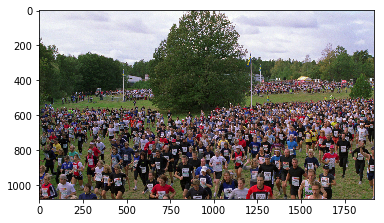

In [92]:
plt.imshow(image)

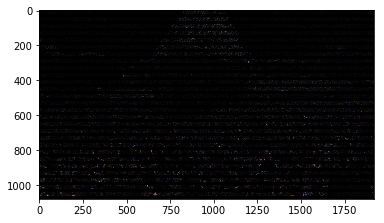

In [97]:
plt.imshow(np.abs(gt_video[1].astype('int16') - image.astype('int16')))

### Your Code

Рекомендуем начать с простого алгоритма, добиться его работоспособности и приемлемого качества, а затем итеративно усложнять модель и подбирать параметры.

Следующие функции могут оказаться полезными:
* `cv2.calcOpticalFlowFarneback` — вычисляет Optical Flow (подробнее: [док](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af), [туториал](https://docs.opencv.org/3.4/d7/d8b/tutorial_py_lucas_kanade.html))

In [ ]:
def deinterlace_video(fields):
    num_frames, height, width, num_channels = fields.shape
    deinteraced_video = np.zeros((num_frames, height * 2, width, num_channels), dtype='uint8')
    
    # PUT YOUR CODE HERE
    
    return deinterlaced_video

## Часть 2. Нейросетевой деинтерлейсер

### TensorFlow

В качестве фреймворка машинного обучения был выбран **TensorFlow**.

Он хорош по следующим причинам:
* гибкость
* простота использования
* есть высокоуровневая обёртка Keras, сразу же встроенная в пакет TF
* хорошая стабильная поддержка
* интегрированность с Python и C++
* эффективная работа с GPU

Единственным недостатком является сложность на начальных этапах освоения. Но мы верим, что вы справитесь!

### Google Colab

В 2018 году Google выпустил приложение Colaboration (или Colab), где предоставляет в бесплатное (!) пользование видеокарты Tesla K80 12GB по следующим правилам:
* видеокарту можно использовать непрерывно 12 часов
* затем 12-часовой перерыв и снова можно пользоваться

Поэтому, если вы случайно не обладаете маленьким кластером мощных GPU, мы рекомендуем воспользоваться этим щедрым предложением. Все необходимые инструкции по работе с Google Colab описаны в гайде по ссылке: <вставить ссылку>

### Установка Tensorflow (CPU/GPU)

Если вы всё же решили использовать свои мощности, нужно определиться с версией TF:
* `tensorflow` — это пакет предназначен _только_ для вычислений на CPU
* `tensorflow-gpu` — предназначен для вычислений на CPU и CUDA-совместимых GPU

Не ошибитесь при выборе <strike>стула</strike> пакета.

In [ ]:
# pip install tensorflow-gpu
# pip install tensorflow